# API Development

This is already in active development:
https://github.com/lukas-weber/Carlo.jl

In [1]:
using Random 
#########################
# Core Abstractions
#########################
abstract type AbstractSystem end
abstract type AbstractAlgorithm end
abstract type AbstractUpdate end
abstract type AbstractMeasurement end

##########################
# System API
##########################
# for equilibrium simulations
struct NullSystem <: AbstractSystem end

## Measurements

In [2]:
using StatsBase
struct Measurement{F,T}
    observable::F
    data::T  # Vector, Histogram, etc.
end
Measurement(pair::Pair{<:Function}) = Measurement(pair.first, pair.second)
# single measurement
function measure!(measurement::Measurement, sys; kwargs...)
    value = measurement.observable(sys)
    push!(measurement.data, value)
end

# A collection of measurements with intervalled timing
mutable struct Measurements{K}
    measurements::Dict{K, Measurement}
    interval
    _checkpoint
    Measurements(measurements::Dict{K, Measurement}; interval) where K = new{K}(measurements, interval, 0)
end
function Measurements(pairs::Vector{<:Pair{K}}; interval) where K <: Union{Symbol, String}
    measurements = Dict{K, Measurement}(name => Measurement(pair) for (name, pair) in pairs)
    Measurements(measurements, interval=interval)
end
Base.getindex(m::Measurements{K}, key::K) where K = m.measurements[key]
Base.setindex!(m::Measurements{K}, val, key::K) where K = m.measurements[key] = val

# measurement with intervals (if discrete in time, then t is an integer step)
function measure!(measurements::Measurements, sys, t; kwargs...)
    if t >= measurements._checkpoint
        for (name, measurement) in measurements.measurements
            measure!(measurement, sys; kwargs...)
        end
        measurements._checkpoint += measurements.interval
    end
end

measure! (generic function with 2 methods)

## Equilibriium

In [22]:
# abstract type ImportanceSampling <: AbstractAlgorithm end
# create basic fields for importance sampling algorithms
abstract type AbstractImportanceSampling <: AbstractAlgorithm end
function delta_log_weight(alg::AbstractImportanceSampling, sys::AbstractSystem, dx)
    error("log_weight not implemented for $(typeof(alg)) and $(typeof(sys))")
end

# TODO: algorithm should own the log_weight_proposal function! Right now, we anyways define it externally. Then we may as well pass it to the algorithm.?
# Important: depending on whether the algorithm has a delta_log_weight or a log_weight function, this could distinguish between the two cases.
@inline function accept!(alg::AbstractImportanceSampling, sys::AbstractSystem, dx) 
    alg.steps += 1

    _delta_log_weight = delta_log_weight(alg, sys, dx)
    accepted = _delta_log_weight > 0 || rand(alg.rng) < exp(_delta_log_weight)

    alg.accepted += accepted 
    return accepted
end

accept! (generic function with 1 method)

### Example: Distribution sampling

In [25]:
mutable struct Distribution{F} <: AbstractSystem where F
    x :: Any
    logpdf :: F
end

mutable struct DistributionSampling <: AbstractImportanceSampling
    rng :: AbstractRNG
    steps :: Int
    accepted :: Int
    DistributionSampling(rng::AbstractRNG) = new(rng, 0, 0)
end
delta_log_weight(alg::DistributionSampling, sys::Distribution, dx) = sys.logpdf(sys.x + dx) - sys.logpdf(sys.x)

delta_log_weight (generic function with 2 methods)

Acceptance rate: 0.7048451548451549


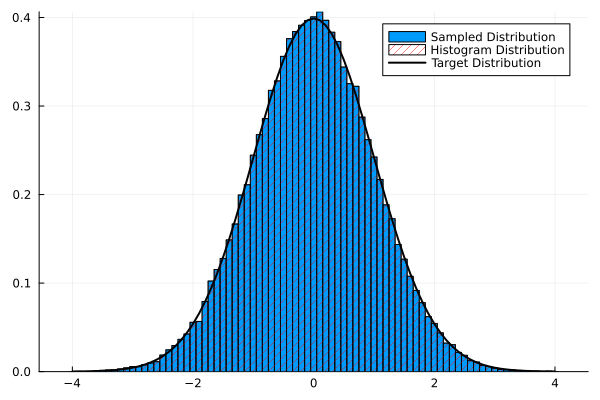

In [26]:
using Random
sys = Distribution(0.0, x -> -x^2/2.0)
alg = DistributionSampling(MersenneTwister(42))

# needs to be defined for each system + algorithm pair
function update!(sys, alg)
    dx = randn(alg.rng) # proposal step
    if accept!(alg, sys, dx) # old state is stored in sys for this example
        sys.x += dx
    end
end
update!(sys) = update!(sys, alg)

bins = collect(-4.05:0.1:4.05)
measurements = Measurements([
    :timeseries => (sys->sys.x) => Float64[],
    :histogram => (sys->sys.x) => fit(Histogram, Float64[], bins)
], interval=10)

for i in 1:1e3
    # update or next
    update!(sys, alg)
end
for i in 1:1e6
    update!(sys, alg)
    measure!(measurements, sys, i)
end

print("Acceptance rate: ", alg.accepted / alg.steps, "\n")
#plot distribution
using Plots
using Distributions
histogram(measurements[:timeseries].data, bins=bins, normalize=true, label="Sampled Distribution")
meas_dist = StatsBase.normalize(measurements[:histogram].data, mode=:pdf)
plot!(meas_dist, label="Histogram Distribution", alpha=0.5, fillalpha=0.5, fillcolor=:red, fillstyle=:/)
x = -4:0.1:4
plot!(x, pdf.(Normal(0,1), x), label="Target Distribution", color=:black, lw=2)

### Example: Ising

In [38]:
abstract type AbstractSpinSystem <: AbstractSystem end
@inline pick_site(rng, N) = rand(rng, UInt) % N + 1

########################
# general spin flip that would come with SpinSystems (currently in use for BC)
########################
function SpinFlip(sys::AbstractSpinSystem, alg::AbstractImportanceSampling)
    # pick a random spin (from the possible sites -> )
    i = pick_site(alg.rng, length(sys.spins))
    # system knows the possible spin states at site i
    s_new = rand(alg.rng, sys.states)
    E = energy(sys)
    dE = energy_change(sys, i, s_new)

    if accept!(alg, sys, (E+dE, E)) 
        modify!(sys, i, s_new, dE) #<- modify the system to implement update 
    end # in other update schemes this may include a rejection step instead
end
@inline function _local_spin_pairs(sys::AbstractSpinSystem, i)
    s = sys.spins[i]
    acc = 0
    for j in sys.nbrs[i]
        acc += s * sys.spins[j]
    end
    return acc
end

_local_spin_pairs (generic function with 1 method)

In [39]:
log_dos_beale_8x8 = [ (-128, 0.6931471805599453), (-124, 0.0), (-120, 4.852030263919617), (-116, 5.545177444479562), (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714), (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282), (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693), (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573), (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176), (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314), (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422), (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285), (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975), (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425), (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592), (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369), (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109), (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369), (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898), (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614), (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256), (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947), (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063), (116, 5.545177444479562), (120, 4.852030263919617), (124, 0.0), (128, 0.6931471805599453) ];
struct BoltzmannDistribution <: ContinuousUnivariateDistribution
    pdf::Dict{Any,Float64}
    function log_sum(a::Number, b::Number)::Float64
        if b < a
            return a + log(1 + exp(b - a))
        else
            return b + log(1 + exp(a - b))
        end
    end
    function initialize_BoltzmannDistribution(beta, log_dos)
        # partition sum
        log_Z = -Inf
        for (E, log_d) in log_dos
            log_Z = log_sum(log_Z, log_d - beta * E)
        end

        pdf = Dict{Int64,Float64}()
        for (E, log_d) in log_dos
            log_pdf = log_d - beta * E - log_Z
            pdf[E] = exp(log_pdf)
        end
        return pdf
    end
    BoltzmannDistribution(beta, log_dos) = new(initialize_BoltzmannDistribution(beta, log_dos))
end

In [40]:
##########################
# Ising
##########################
using Graphs
# TODO: generalize to H = - \sum J_{ij}s_i s_j + mu \sum_i h_i s_i
# and work our way from there?
mutable struct Ising{T} <: AbstractSpinSystem   
    spins :: Vector{Int8}            # ±1
    graph :: SimpleGraph
    nbrs  :: Vector{Vector{Int}}    # precomputed neighbors
    J     :: T
    sum_pairs :: Int                # sum of s_i s_j over edges
    sum_spins :: Int                # sum of spins

    function Ising(graph::SimpleGraph, J)
        T = typeof(J)
        nbrs = [collect(Graphs.neighbors(graph, i)) for i in 1:nv(graph)]

        # all spins = +1 ⇒ each pair contributes +1
        spins = ones(Int8, nv(graph))
        sum_pairs = ne(graph)
        sum_spins = nv(graph)

        new{T}(spins, graph, nbrs, J, sum_pairs, sum_spins)
    end
end
# Convenience lattice constructor
function Ising(dims::Vector{Int}; J=1, periodic=true)
    graph = Graphs.SimpleGraphs.grid(dims; periodic)
    return Ising(graph, J)
end


function init(sys::Ising, type::Symbol, rng=nothing, states=[-1, 1])
    if type == :up
        sys.spins .= 1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = length(sys.spins)
    elseif type == :down
        sys.spins .= -1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = -length(sys.spins)
    elseif type == :random
        @assert rng !== nothing
        for i in eachindex(sys.spins)
            sys.spins[i] = rand(rng, states)
        end
        # recompute bookkeeping
        sum_pairs = zero(sys.J)
        for i in 1:length(sys.spins)
            sum_pairs += _local_spin_pairs(sys, i)
        end
        sys.sum_pairs = sum_pairs/2
        sys.sum_spins = sum(sys.spins)
    end
    return sys
end

# ------------------------------------------------------------
# Observables
# ------------------------------------------------------------

@inline magnetization(sys::Ising) = abs(sys.sum_spins)
@inline energy(sys::Ising) = -sys.J * sys.sum_pairs

@inline energy_change(sys::Ising, i) =
    2 * sys.J * _local_spin_pairs(sys, i)

# for spin updates
@inline function modify!(sys::Ising, i, dE)
    old = sys.spins[i]
    new = -old
    sys.spins[i] = new

    # bookkeeping 
    sys.sum_pairs -= dE / sys.J 
    sys.sum_spins += 2 * new

    return nothing
end

function SpinFlip(sys::Ising, alg::AbstractImportanceSampling)
    i = rand(1:length(sys.spins))
    dE = energy_change(sys, i)

    if accept!(alg, sys, dE) 
        modify!(sys, i, dE)
    end
end

SpinFlip (generic function with 2 methods)

In [41]:
###########################
# Specific Metropolis
###########################
mutable struct Metropolis <: AbstractImportanceSampling
    rng :: AbstractRNG
    beta :: Real
    steps :: Int
    accepted :: Int
    Metropolis(rng::AbstractRNG; beta::Real) = new(rng, beta, 0, 0)
end
@inline delta_log_weight(alg::Metropolis, sys::AbstractSystem, dx) = -alg.beta * dx 

delta_log_weight (generic function with 4 methods)

In [42]:
using Random 
rng = MersenneTwister(42)
sys = Ising([8,8])
init(sys, :random, rng)
alg = Metropolis(rng, beta=0.3)

measurements = Measurements([
    :energy => energy => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
N = nv(sys.graph)
println("Total spins: ", N)

# benchmark the spinflip here
using BenchmarkTools
@btime SpinFlip(sys, alg)

for i in 1:N*1e3
    SpinFlip(sys, alg)
end

# measurement
for i in 1:N*1e4
    SpinFlip(sys, alg)
    measure!(measurements, sys, i)
end

# print results
println("Acceptance rate: ", alg.accepted / alg.steps)
println("Average energy: ", mean(measurements[:energy].data)/N)
println("Average magnetization: ", mean(measurements[:magnetization].data)/N)

Total spins: 64
  327.290 ns (8 allocations: 137 bytes)
Acceptance rate: 0.5186448685770421
Average energy: -0.7088268152060124
Average magnetization: 0.27546298104717115


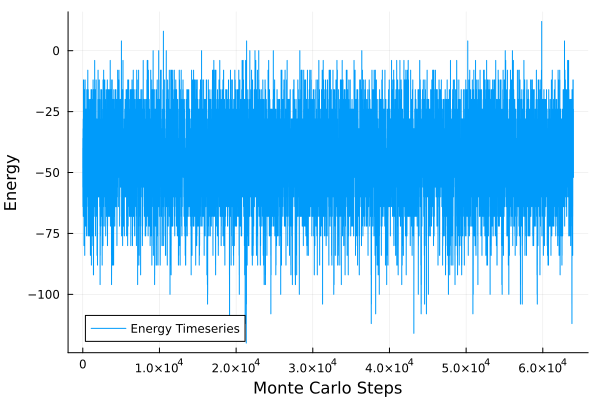

In [43]:
# plot timeseries
using Plots
energies = measurements[:energy].data
plot(energies, label="Energy Timeseries", xlabel="Monte Carlo Steps", ylabel="Energy")

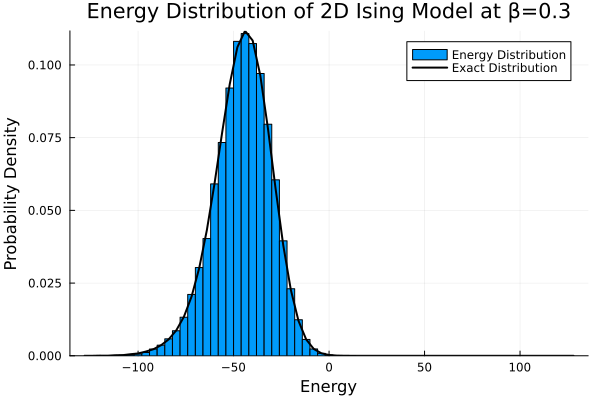

In [44]:
# plot distribution of energy compared to exact
using Plots
energies = measurements[:energy].data
hist = fit(Histogram, energies, minimum(energies)-2:4:maximum(energies)+2, closed=:left)
dist = StatsBase.normalize(hist, mode=:probability)
plot(dist, label="Energy Distribution", xlabel="Energy", ylabel="Probability Density",
    title="Energy Distribution of 2D Ising Model at β=$(alg.beta)")
# exact histogram
P_true = BoltzmannDistribution(alg.beta, log_dos_beale_8x8).pdf
E_vals = sort(collect(keys(P_true)))
P_vals = [P_true[E] for E in E_vals]
plot!(E_vals, P_vals, label="Exact Distribution", color=:black, lw=2)

## Example: Sweep

In [47]:
# BlumeCapel (could most definitely be optimized further)
mutable struct BlumeCapel <: AbstractSpinSystem   
    spins :: Vector{Int8}            # -1, 0, +1
    graph :: SimpleGraph
    nbrs  :: Vector{Vector{Int}}    # precomputed neighbors
    states :: Vector{Int8}          # possible spin states
    J     :: Real
    D     :: Real
    sum_pairs :: Int                # sum of s_i s_j over edges
    sum_spins :: Int                # sum of spins
    sum_spins2 :: Int               # sum of s_i^2

    function BlumeCapel(graph::SimpleGraph, J, D)
        nbrs = [collect(Graphs.neighbors(graph, i)) for i in 1:nv(graph)]
        states = Int8[-1, 0, 1]

        # all spins = +1 ⇒ each pair contributes +1
        spins = ones(Int8, nv(graph))
        sum_pairs = ne(graph)
        sum_spins = nv(graph)
        sum_spins2 = nv(graph)

        new(spins, graph, nbrs, states,J, D, sum_pairs, sum_spins, sum_spins2)
    end
end
# Convenience lattice constructor
function BlumeCapel(dims::Vector{Int}; J=1, D=0, periodic=true)
    graph = Graphs.SimpleGraphs.grid(dims; periodic)
    return BlumeCapel(graph, J, D)
end
function init(sys::BlumeCapel, type::Symbol, rng=nothing) 
    if type == :up
        sys.spins .= 1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = length(sys.spins)
        sys.sum_spins2 = length(sys.spins)
    elseif type == :down
        sys.spins .= -1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = -length(sys.spins)
        sys.sum_spins2 = length(sys.spins)
    elseif type == :zero
        sys.spins .= 0
        sys.sum_pairs = 0
        sys.sum_spins = 0
        sys.sum_spins2 = 0
    elseif type == :random
        @assert rng !== nothing
        for i in eachindex(sys.spins)
            sys.spins[i] = rand(rng, sys.states)
        end
        # recompute bookkeeping
        sum_pairs = zero(sys.J)
        sum_spins = 0
        sum_spins2 = 0
        for i in 1:length(sys.spins)
            sum_pairs += _local_spin_pairs(sys, i)
            sum_spins += sys.spins[i]
            sum_spins2 += sys.spins[i]^2
        end
        sys.sum_pairs = sum_pairs/2
        sys.sum_spins = sum_spins
        sys.sum_spins2 = sum_spins2
    end
    return sys
end

@inline energy(sys::BlumeCapel) = [-sys.J * sys.sum_pairs, sys.D * sys.sum_spins2]
@inline magnetization(sys::BlumeCapel) = abs(sys.sum_spins)
@inline energy_change(sys::BlumeCapel, i, s_new) = 
    [2 * sys.J * _local_spin_pairs(sys, i), sys.D * (s_new^2 - sys.spins[i]^2)]
@inline function modify!(sys::BlumeCapel, i, s_new, dE)
    old = sys.spins[i]
    sys.spins[i] = s_new 
    # bookkeeping
    sys.sum_pairs -= dE[1] / sys.J 
    sys.sum_spins += s_new - old
    sys.sum_spins2 += s_new^2 - old^2
    # throw error if sum_spins2 < 0
    if sys.sum_spins2 < 0
        error("sum_spins2 became negative: ", sys.sum_spins2)
    end
    return nothing
end

# needs to redefine the log_weight_proposal
@inline function delta_log_weight(alg::Metropolis, sys::AbstractSystem, dE) 
    E_new, E_old = dE
    return -alg.beta * (sum(E_new) - sum(E_old))
end

delta_log_weight (generic function with 4 methods)

In [48]:
using Random 
rng = MersenneTwister(42)
sys = BlumeCapel([8,8])
init(sys, :random, rng)
alg = Metropolis(rng, beta=0.3)

measurements = Measurements([
    :energy => (sys->sum(energy(sys))) => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
N = nv(sys.graph)
println("Total spins: ", N)

# benchmark the spinflip here
using BenchmarkTools
@btime SpinFlip(sys, alg)

function sweep(sys, alg)
    #ClusterUpdate(alg.rng, sys, version="Wolff" # <- not implemented yet
    for n in 1:3*N
        SpinFlip(sys, alg)
    end
end

for i in 1:1e3
    sweep(sys, alg)
end

# measurement
for i in 1:1e4
    sweep(sys, alg)
    measure!(measurements, sys, i)
end

# print results
println("Acceptance rate: ", alg.accepted / alg.steps)
println("Average energy: ", mean(measurements[:energy].data)/N)
println("Average magnetization: ", mean(measurements[:magnetization].data)/N)

Total spins: 64
  1.492 μs (17 allocations: 435 bytes)
Acceptance rate: 0.660918466020842
Average energy: 29.736060814185816
Average magnetization: 0.1833635114885115


## Example: Muca

In [49]:
# multicanonical algorithm analogous to Metropolis (can be done custom as here, but later profits from advantage of helper functions, parallelization and stuff?)
abstract type GeneralizedEnsemble <: AbstractImportanceSampling end
mutable struct Multicanonical{T} <: GeneralizedEnsemble
    rng :: AbstractRNG
    steps :: Int
    accepted :: Int
    bins :: T
    log_weights :: Vector{Float64}
    Multicanonical(rng::AbstractRNG, bins) = new{typeof(bins)}(rng, 0, 0, bins, zeros(Float64, length(bins)))
end

mutable struct MyAlgorithm <: GeneralizedEnsemble
    rng :: AbstractRNG
    steps :: Int
    accepted :: Int
    log_weights :: Vector{Float64}
    beta :: Real
    MyAlgorithm(rng::AbstractRNG, bins; beta::Real) = new(rng, 0, 0, zeros(Float64, length(bins)), beta)
end

In [50]:
sys = BlumeCapel([8,8], J=1, D=0) 
rng = MersenneTwister(42)
init(sys, :random, rng)
N = nv(sys.graph)
alg = MyAlgorithm(rng, 0:N, beta=0.3)

# need to redfine what energy and energy_change mean here
@inline energy(sys::BlumeCapel) = [-sys.J * sys.sum_pairs, sys.sum_spins2]
@inline energy_change(sys::BlumeCapel, i, s_new) = 
    [2 * sys.J * _local_spin_pairs(sys, i), s_new^2 - sys.spins[i]^2]
@inline function delta_log_weight(alg::MyAlgorithm, sys::BlumeCapel, E_change)
    E_new, E_old = E_change
    d_E_J = E_new[1]- E_old[1]
    metropolis_part = -alg.beta * sys.J * d_E_J
    # access currently ad-hoc because J=1 integer so that E is Vector{Int}
    muca_part = alg.log_weights[1 + E_new[2]] - alg.log_weights[1 + E_old[2]]
    return metropolis_part + muca_part
end

final_measurements = Measurements([
    :E_J => (sys->energy(sys)[1]) => Float64[],
    :E_D => (sys->energy(sys)[2]) => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
for i in 1:1e3
    SpinFlip(sys, alg)
end

function muca_iteration(sys, alg, updates)
    histogram_E_D = Measurement(sys->energy(sys)[2], fit(Histogram, Int[], 0:100, closed=:left))
    for i in 1:updates
        SpinFlip(sys, alg)
        measure!(histogram_E_D, sys)
    end
    return histogram_E_D
end

histograms = []
log_weights = []
iterations = 10
using ProgressMeter
@showprogress for iter in 1:iterations
    hist_E_D = muca_iteration(sys, alg, 1e4*N)
    push!(histograms, hist_E_D)
    # update log_weights
    for bin in 1:length(alg.log_weights)
        count = hist_E_D.data.weights[bin]
        if count > 0
            alg.log_weights[bin] -= log(count)
        end
    end
    push!(log_weights, collect(alg.log_weights))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


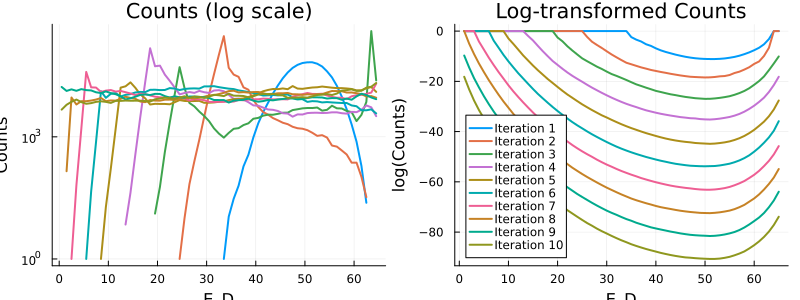

In [51]:
# plot histograms
using Plots
# Create 2-panel plot
p1 = plot(yscale=:log, xlabel="E_D", ylabel="Counts", legend=:none, title="Counts (log scale)")
p2 = plot(xlabel="E_D", ylabel="log(Counts)", legend=:best, title="Log-transformed Counts")

for (i, hist) in enumerate(histograms)
    data = hist.data
    edges = data.edges[1]
    bin_centers = (edges[1:end-1] .+ edges[2:end]) ./ 2
    weights = data.weights
    
    # Only plot non-zero values
    mask = weights .> 0   
    if sum(mask) == 1
        # plot a scatter
        plot!(p1, bin_centers[mask], weights[mask], seriestype=:scatter,
              label="Iteration $i", markersize=4)
    else
        plot!(p1, bin_centers[mask], weights[mask], 
              label="Iteration $i", linewidth=2)
    end
end
for (i, log_weights) in enumerate(log_weights)
    plot!(p2, log_weights, 
          label="Iteration $i", linewidth=2)
end

# Combine into 2-panel figure
plot(p1, p2, layout=(1, 2), size=(800, 300))

## Example: PT

In [18]:
# sys = Ising(L=10,J=1,d=2)
# rng = MersenneTwister(42)
# alg = ParallelTempering(rng, betas=[0.5, 1.0, 1.5, 2.0])
# # ReplicaExchange(rng, weights=[...])
# # ParallelTempering = ReplicaExchange 

# # the update function defines all the dynamics (links system and algorithm)
# function SpinFlip(sys::Ising, alg::ReplicaExchange)
#     # pick a random spin
#     i = rand(1:sys.N)
#     # this would need to be adapted for other algorithms e.g. PT in sub energy
#     dE = sys.dE(i)
#     # pass to importance sampling algorithm
#     if accept!(alg, sys, dE) # accept stores the acceptance rate etc in the algorithm
#         sys.spins[i] = -sys.spins[i] # flip spin
#     end
# end
# update!(sys) = SpinFlip(sys, alg, 0)

# # TODO: add replica exchange step every n steps and parallel structure!

# sim = Simulation(sys, update!)

# # thermalization
# run!(sim, 100)  
# # measurement
# run!(sim, 1e4, measure!)

## Example: Gillespie

In [68]:
# create a minimal Gillespiel example analoguous to the above Ising case
mutable struct BirthDeathProcess <: AbstractSystem
    N :: Real
    lambda :: Real
    mu :: Real
    rates :: Vector{Real} # population birth and death rates 
    BirthDeathProcess(N0::Int, lambda::Real, mu::Real) = new(N0, lambda, mu, [lambda*N0, mu*N0])
end

# define how the system changes upon a birth or a death event 
# TODO: event could be a symbol (:birth, :death) that is returned ... would this be performant?
function modify!(sys::BirthDeathProcess, event::Int)
    if event == 1 # :birth
        sys.N += 1
    elseif event == 2 # :death
        sys.N -= 1
    end
    # adapt rates 
    sys.rates[1] = sys.lambda * sys.N
    sys.rates[2] = sys.mu * sys.N
    return nothing
end

# Gillespie algorithm (should Gillespie have the rates? Can it inherit them from the system?). 
# analogous to a pointer onto the system!
mutable struct Gillespie <: AbstractAlgorithm
    rng :: AbstractRNG
    steps :: Int
    time :: Float64
    Gillespie(rng::AbstractRNG) = new(rng, 0, 0.0)
end

using MonteCarloX
# use MonteCarloX next! function (for now pass sys manually)
function next(alg::Gillespie, sys::BirthDeathProcess)
    sum_rates = sum(sys.rates)
    if !(sum_rates > 0)
        return Inf, 0
    end
    dtime = MonteCarloX.next_time(alg.rng, sum_rates)
    event = MonteCarloX.next_event(alg.rng, sys.rates)
    return dtime, event
end

next (generic function with 2 methods)

In [78]:
sys = BirthDeathProcess(10, 0.5, 0.4)
alg = Gillespie(MersenneTwister(42))

# this sets up a continuous measurement. Important to measure before modifying the system state!
measurements = Measurements([
    :timeseries => (sys->sys.N) => Float64[],
], interval=1.0)

T=1e2
t=0.0
# add a custom progressmeter
using ProgressMeter
while t < T
    dt, id = next(alg, sys)
    t += dt
    # do measurement if t_meas < t 
    measure!(measurements, sys, t)
    # modify system state
    modify!(sys, id)
end

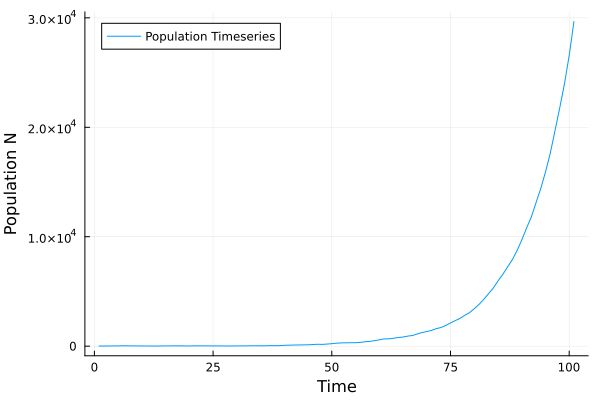

In [ ]:
# plot the timeseries
using Plots
plot(measurements[:timeseries].data, label="Population Timeseries", xlabel="Time", ylabel="Population N")